In [1]:
from Environnement import Env
from NNs import FFIndiv
from collections import namedtuple
from Archive import Archive

import ES
import numpy as np
import Samplers
import datetime

import matplotlib.pyplot as plt
from matplotlib import animation

In [43]:
def rastrigin(x):
    return -(20 + (x[0]*5.12)**2 + (x[1]*5.12)**2 - 10 * (np.cos(2*np.pi*x[0]*5.12) + np.cos(2*np.pi*x[1]*5.12)))

def radial_func(x):
    return np.cos(10 * np.pi * (x[0] ** 2 + x[1] ** 2)) * np.exp(-(x[0] ** 2 + x[1] ** 2))

def ackley(x):
    x = np.array(x)/5
    res = -20 * np.exp(-0.2 * np.linalg.norm(x) * np.sqrt(0.5)) 
    res -= np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
    return -res

Best/Average score in pop 0: 0.17, 0.00 ; Reused 0 samples
Best/Average score in pop 0: 0.19, 0.01 ; Reused 80 samples
Best/Average score in pop 1: 0.23, -0.01 ; Reused 80 samples
Best/Average score in pop 2: 0.50, -0.01 ; Reused 80 samples
Best/Average score in pop 3: 0.66, 0.01 ; Reused 80 samples
Best/Average score in pop 4: 0.99, 0.02 ; Reused 80 samples
Best/Average score in pop 5: 1.00, 0.03 ; Reused 80 samples
Best/Average score in pop 6: 1.00, 0.09 ; Reused 80 samples
Best/Average score in pop 7: 1.00, 0.12 ; Reused 80 samples
Best/Average score in pop 8: 1.00, 0.17 ; Reused 80 samples
Best/Average score in pop 9: 1.00, 0.15 ; Reused 80 samples
Best/Average score in pop 10: 1.00, 0.23 ; Reused 80 samples
Best/Average score in pop 11: 1.00, 0.28 ; Reused 80 samples
Best/Average score in pop 12: 1.00, 0.31 ; Reused 80 samples
Best/Average score in pop 13: 1.00, 0.47 ; Reused 80 samples
Best/Average score in pop 14: 1.00, 0.67 ; Reused 80 samples
Best/Average score in pop 15: 1.00

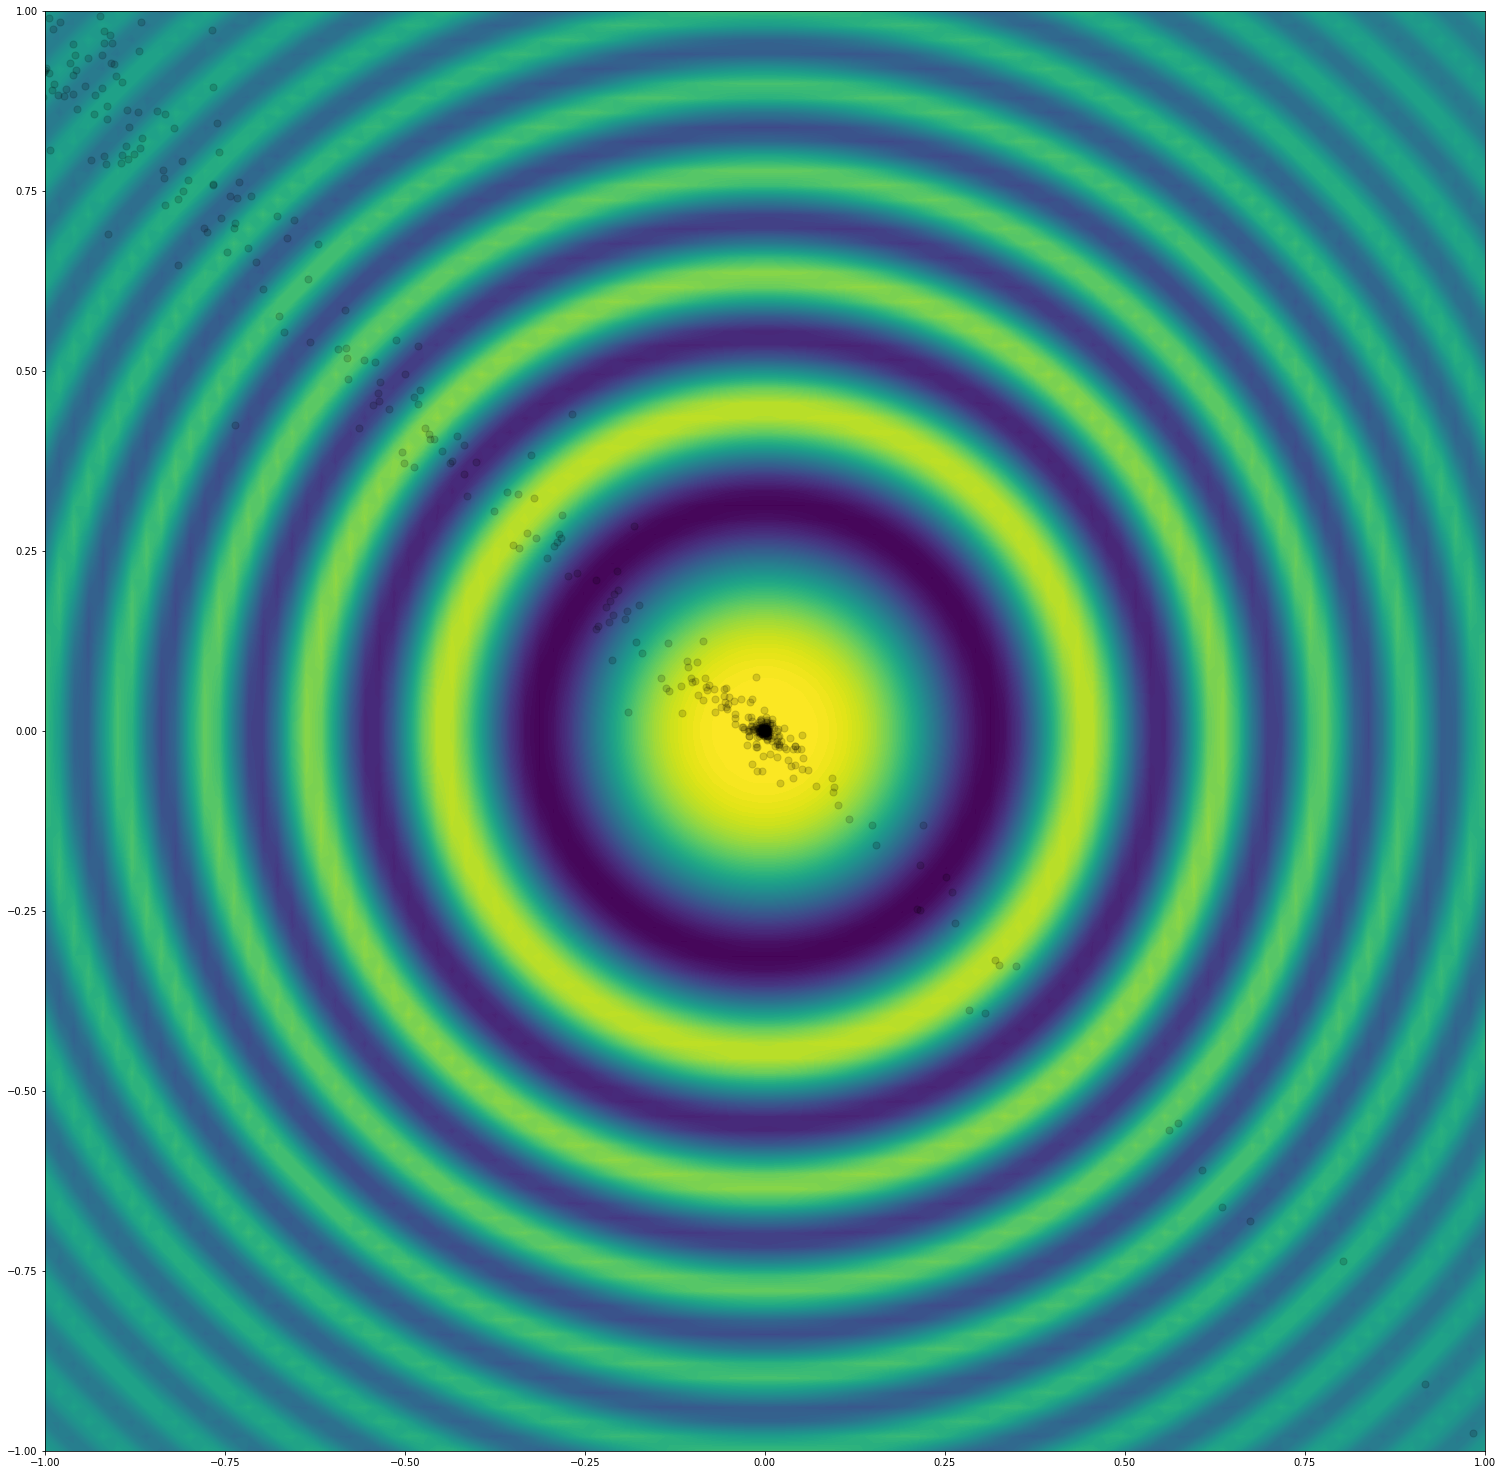

In [48]:
create_clip(radial_func, ES.CMAES, Samplers.ClosestSampler, accept_ratio=0.8, n_frames=50, verbose=True, 
            mu_init=[-1, 1], sigma_init=0.01, pop_size=100, show_archive=True)

In [4]:
def create_clip(fit_function, optimizer_class, sampler_class, filename=None, accept_ratio=0.75, 
                n_frames=1000, pop_size=100, mu_init=[0, 0], sigma_init=0.1, show_archive=False, verbose=False):
    
    # misc
    best_params = mu_init
    best_score = fit_function(best_params)
    if filename is None:
        now = datetime.datetime.now()
        filename = "videos/" + fit_function.__name__ + "_" + optimizer_class.__name__ + "_" + \
                    sampler_class.__name__ + "_" + str(now.hour) + "h" + str(now.minute) + "m" + str(now.second) + 's.mp4'
    
    # optimizer
    optimizer = optimizer_class(2, pop_size=pop_size, mu_init=mu_init, sigma_init=sigma_init)

    # archives
    Sample = namedtuple('Sample', ('params', 'score', 'gens'))
    Theta = namedtuple('Theta', ('mean', 'cov'))
    sample_archive = Archive(max_size=n_frames * pop_size)
    thetas_archive = Archive(max_size=n_frames)
    mean, cov = optimizer.get_distrib_params()
    thetas_archive.add_sample(Theta(mean, cov))

    # sampler
    sampler = sampler_class(sample_archive, thetas_archive, accept_ratio=accept_ratio)
    
    # training
    def train(i):

        batch, n_reused, idx_reused, scores_reused = sampler.ask(
        pop_size, optimizer)
        scores = np.zeros(optimizer.pop_size)

        # reused samples
        for j in range(n_reused):

            scores[j] = scores_reused[j]

        # newly drawn samples
        for j in range(n_reused, pop_size):

            score = fit_function(batch[j])
            sample_archive.add_sample(Sample(batch[j], score, [i]))
            scores[j] = score

            if score > best_score:
                best_params = batch[j]

        # statistics on the current batch
        if verbose:
            print("Best/Average score in pop {0}: {1:.2f}, {2:.2f}".format(
                i, np.max(scores), np.mean(scores)),
                "; Reused {} samples".format(n_reused))

        # optimization step
        optimizer.tell(batch, scores)
        mu, cov = optimizer.get_distrib_params()
        thetas_archive.add_sample(Theta(mu, cov))

        return batch, n_reused
    
    
    fig, ax = plt.subplots(figsize=(20, 20))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))

    # contour of fit function
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    z = np.array([fit_function([i, j]) for j in y for i in x])

    X, Y = np.meshgrid(x, y)
    Z = z.reshape(100, 100)
    contour = ax.contourf(X, Y, Z, 100)
    scatter_new = ax.scatter([], [], c='b', s=100, alpha=0.6)
    scatter_old = ax.scatter([], [], c='r', s=100, alpha=0.6)

    def animate(i):
        batch, n_reused = train(i)
        scatter_new.set_offsets(np.c_[batch[n_reused:,0], batch[n_reused:,1]])
        scatter_old.set_offsets(np.c_[batch[:n_reused,0], batch[:n_reused,1]])
        if show_archive:
            ax.scatter(batch[n_reused:,0], batch[n_reused:,1], s=50, c='black', alpha=0.15)

    anim = animation.FuncAnimation(fig, animate, np.arange(0, n_frames+1), blit=False, interval=500)
    anim.save(filename)